## Standard Loans ##

<hr class="header-line"/>

We are going to use the [Loss Model and simulation tools](loss.ipynb#Loss-Models) we have developed to generate a projection for Opco and Fico performance. 

<p class="p-break"></p>

We can then use the projection to evaluate:

1. investment required
2. attractiveness of the investment

<p class="p-break"></p>

### Inputs ###

+ 15 years, tracked quarterly
+ **Loan Growth**: target of `$`4MM of new originations *per quarter* by Year 15
+ **Loan Size**: average loan size of `$`100K growing to `$`300K by Year 15
+ **Credit Quality**: average BB+/BB rating
+ **LGD**: calculated using [Fair Market Value (FMV)](lgd.ipynb) approach. 10% liquidation costs assumed.
+ **Pricing**: [market-driven pricing](pricing.ipynb#Market-Driven) utilized. Current public debt rates available from [St. Louis Federal Reserve](https://fred.stlouisfed.org/categories/32348). Missing ratings is interpolated.
    + Additional markups (total eyeball):
        + Liquidity Premium: 1%
        + Credit Risk Premium: 0.5%
        + Profit: 1%
    + Minimum Rate: 4.5%
+ **Cost of Debt to Opco**: LIBOR + 1.4%

<p class="p-break"></p>

### Assumptions ###

+ All loans amortized over 5 years
+ PDs do not change over time
+ PDs are correlated
+ FMV depreciation curve is the same for each loan
+ FMV depreciation estimated using tried-on-true "eyeball" approach
+ PDs and LGDs are *not* correlated

<p class="p-break"></p>

### Process ####

1. generate new loan originations
2. generate borrower credit ratings and assign PDs
3. generate default correlation matrix
4. generate pricing targets at each credit rating
5. generate FMV depreciation curve
6. assign FMV to each loan *for each quarter in the projection*
    + FMV is further augmented as normally-distributed around expected FMV
7. For each Year in the projection
    + build loss model based on new and existing loans (carried forward from prior quarter)
    + generate 15,000 simulations for *each quarter* and build loss distribution
    + assign pricing based on credit quality
    + assign economic capital required
    + assign payment and amortization schedules for new loans
8. Build financial statements from the quarterly proe

<p class="p-break"></p>

### Building the Code ###

Here we build out the loan code.

In [78]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import invgauss, bernoulli as bern, norm, beta, lognorm, expon, genexpon, genextreme
from scipy.linalg import eig, eigh, cholesky, svd, eigvals, schur
from scipy.special import errstate as sci_errstate
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from IPython.core.display import display, HTML, Markdown
from IPython.display import Image

import numpy_financial as npf
import dataframe_image as dfi

from htsfi.main import *
from htsfi.helpers import *

update_style()
plt.style.use('htsfi')

def vintshift(col):
    vintage = col.name
    col = df_loans.iloc[:, vintage]
    todate = df_loans.iloc[:, :vintage]
    ntd = todate.notna().sum().sum()
    col = col.shift(ntd)
    
    return col

def norm_to_binom(mu, std):
    p = 1 - std/mu
    n = mu / p

    return n, p

def nan_like(df):
    df_new = np.empty_like(df.values)
    df_new[:] = np.nan

    return pd.DataFrame(df_new)

def line_by_line(x):
    """
    Per formula found here: https://genstat.kb.vsni.co.uk/knowledge-base/rational-functions/
            
            Y = a + b / (c + d*X)
    """
    a = -1
    b = 0
    c = -1
    d = -.5

    return a/(c + d*x) + b

def calc_ret(rev, exp, cap):
    return (rev - exp) / cap

def int_to_make_hurdle(exp, loan, equity, hurdle):
    return (hurdle*equity + exp) / loan

def booksim(vintage, df_loans, p_of_ds, pd_idx, corrmats, fmv, interest, new_nums, econ_caps, charge_offs, rates, int_rates, min_rate=.045, cost_of_debt=.03, hurdle=.3, n_samples=15000, n_amort=20):
    new_nums = new_nums[new_nums[:, 1] == vintage][:, 0]
    col = df_loans.iloc[:, vintage]
    filt = col.notna() | (col == 0)
    loan_nums = np.argwhere(filt.values).ravel()
    EAD = col[filt]
    n = EAD.shape[0]
    
    p_of_d = p_of_ds.iloc[:, vintage]
    p_of_d = p_of_d[p_of_d.notna()].values
    corrmat = corrmats[vintage]
    
    if n < p_of_d.shape[0]:
        length = p_of_d.shape[0] - n
        p_of_d = p_of_d[length:]
        corrmat = corrmat[length:,length:]
        
    e = norm.rvs(0, 1, size=(n, n_samples)) # this creates defaults for ALL borrowers in ALL simulations
    pd_inv = np.repeat(norm.ppf(p_of_d), n_samples).reshape(n_samples, n)

    LAM, S = schur(corrmat)
    eigvals = np.where(np.isclose(np.diag(LAM), 0), 0, np.diag(LAM))
    
    Q = np.sqrt(np.diag(eigvals)) @ np.linalg.inv(S)
    e_prime = Q @ e

    in_default = e_prime.T < pd_inv
    default_per = (e_prime.T < pd_inv).sum() / (n*n_samples)

    losses = np.zeros(in_default.shape)
    i_default = np.argwhere(in_default)
    for i in range(i_default.shape[0]):
        x, y = i_default[i]
        try:
            losses[x, y] = df_loans.values[loan_nums[y], vintage] - fmv.values[loan_nums[y], vintage]
        except Exception as e:
            print (x, y, loan_nums[y], df_loans.values[loan_nums[y], vintage], fmv.values[loan_nums[y]])
            raise e

    i_compli = np.argwhere(~in_default)
    for i in range(i_compli.shape[0]):
        x, y = i_compli[i]
        losses[x, y] = 0
    
    simloss = losses.sum(axis=1)
    simloss_gt0 = simloss[simloss>0]
    if vintage == df_loans.columns[-1] or simloss_gt0.shape[0] == 0:
        mean = 0
        el = 0
        charge_offs[vintage] = el
        econ_cap = 0
        econ_caps[vintage] = econ_cap        
    else:
        params = beta.fit(simloss_gt0)
        ld = beta(*params)
        mean = ld.mean()
        el = ld.mean() / 4
        charge_offs[vintage] = el
        econ_cap = ld.ppf(0.9995)
        econ_caps[vintage] = econ_cap

    # Only perform on NEW LOANS
    new_EAD = df_loans.values[new_nums, vintage]

    # New loans weighted on ALL loans
    weights = new_EAD / EAD.values.sum()
    equity = weights * econ_cap
    debt = new_EAD - equity

    int_on_debt = debt * cost_of_debt
    exp = weights*mean + int_on_debt

    req_int = int_to_make_hurdle(exp, new_EAD, equity, hurdle)

    rate_price = rates[pd_idx[new_nums]]
    rate_price = np.where(rate_price<min_rate, min_rate, rate_price)
    int_rates.append(rate_price)
    pmt = npf.pmt(rate_price/4, n_amort, -new_EAD)

    ipmts = np.zeros((new_EAD.shape[0], n_amort))
    ppmts = np.zeros((new_EAD.shape[0], n_amort))

    for i in range(new_EAD.shape[0]):
        ipmts[i] = npf.ipmt(rate_price[i]/4, np.arange(1, n_amort+1), n_amort, -new_EAD[i])
        ppmts[i] = npf.ppmt(rate_price[i]/4, np.arange(1, n_amort+1), n_amort, -new_EAD[i])

    assert np.all(np.isclose(ipmts[:, 0] + ppmts[:,0], pmt))
    assert np.all(np.isclose(new_EAD, ppmts.sum(axis=1))), (new_EAD, ppmts.sum(axis=1))

    balance = new_EAD[:, None] - ppmts.cumsum(axis=1)
    balance = np.where(np.isclose(balance, 0), 0, balance)
    if balance.ndim == 1:
        balance = balance.reshape(1,balance.shape[0])

    if ipmts.ndim == 1:
        ipmts = ipmts.reshape(1, ipmts.shape[0])

    for x in range(balance.shape[0]):
        df_loans.iloc[new_nums[x], vintage + 1: vintage + 1 + n_amort] = balance[x]

    for x in range(ipmts.shape[0]):
        interest.iloc[new_nums[x], vintage + 1:vintage + 1 + n_amort] = ipmts[x]

    return df_loans, interest, econ_caps, charge_offs, int_rates

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Build Inputs
years = 15
periods = years * 4
n_amort = 5 * 4
loan_tgt = 1000000

dist = expon.pdf(np.arange(periods), 0, periods/3)*periods
originations = (-dist + dist.max()) * loan_tgt

start_avg = 100000
end_avg = 300000
step = (end_avg - start_avg) / (periods)
AVG_LOAN_SIZE = np.arange(start_avg, end_avg, step)

n_loans = np.ceil(originations / AVG_LOAN_SIZE).astype(np.int16)

# Generate New Loans
loans = []
for i in range(n_loans.shape[0]):
    rl = np.random.uniform(0.1, 1, n_loans[i])
    loans.append(originations[i] * rl / rl.sum())

df_loans = pd.DataFrame(loans).T
fillsize = n_loans.sum() - df_loans.shape[0]

filler = np.empty(shape=(fillsize, periods))
filler[:] = np.nan
df_loans = pd.concat([df_loans, pd.DataFrame(filler)])

df_loans = df_loans.apply(vintshift).reset_index(drop=True)

filler = np.empty(shape=(n_amort, n_loans.sum()))
filler[:] = np.nan
df_loans = pd.concat([df_loans.T, pd.DataFrame(filler)]).reset_index(drop=True).T
loan_nums = np.argwhere(df_loans.notna().values)

The code above results in the following loan growth forecasted:

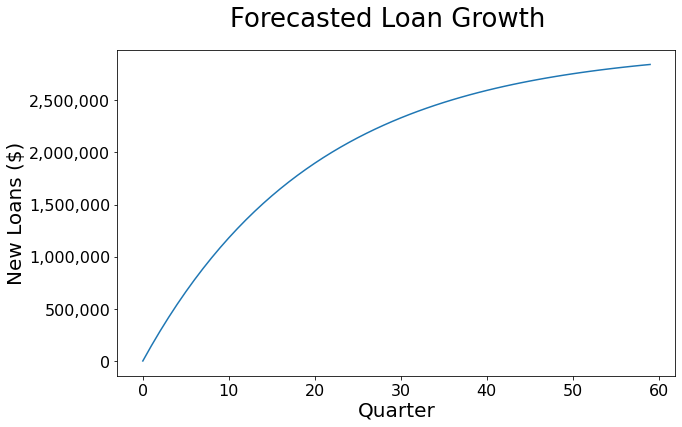

In [19]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
        
    fig, ax = plt.subplots(figsize=(10,6))
    x = np.arange(60)
    ax.plot(x, originations)

    ax.set_yticklabels([f'{t:,.0f}' for t in ax.get_yticks()])
    ax.set_xlabel('Quarter')
    ax.set_ylabel('New Loans ($)')
    plt.suptitle('Forecasted Loan Growth')
    
    plt.show()

In [20]:
# Generate Credit Ratings
mu = 15
std = 6
n, p = norm_to_binom(mu, std)
pd_idx = np.random.binomial(SPs.shape[0], p, n_loans.sum())

Below we show the distribution of credit ratings in the loan portfolio.

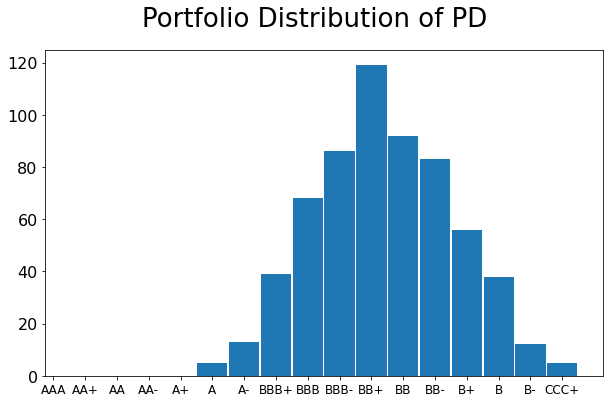

In [21]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
        
    fig, ax = plt.subplots(figsize=(10,6))
    ax.hist(pd_idx, bins=np.arange(1, pd_idx.max() + 1)+.5, rwidth=.95)

    ax.set_xticks(np.arange(1, pd_idx.max() + 1))
    ax.set_xticklabels([f'{SPs[i]}' for i in range(pd_idx.max())])
    
    ax.tick_params('x', labelsize=12)
    plt.suptitle('Portfolio Distribution of PD')
    
    plt.show()

In [22]:
from tqdm.auto import tqdm, trange

In [24]:
# Assign PDs to loans based on Credit Ratings
p_of_ds = nan_like(df_loans)
pd_vars = nan_like(df_loans)

p_of_d = PDs[pd_idx]
pd_var = bern.var(p_of_d)

assert p_of_d.shape[0] == loan_nums.shape[0]

for i in trange(p_of_d.shape[0], leave=False):
    x, y = loan_nums[i]
    p_of_ds.iloc[x,y] = p_of_d[i]
    pd_vars.iloc[x,y] = pd_var[i]

p_of_ds = p_of_ds.ffill(axis=1)
pd_vars = pd_vars.ffill(axis=1)

# Correlation Matrix of Defaults at each Vintage
corrmats = []
for v, col in tqdm(df_loans.iteritems(), total=df_loans.shape[1], leave=False):
    df_todate = df_loans.iloc[:, :v+1]
    n = df_todate.notna().values.sum()

    if n > 0:
        p = np.random.uniform(.3, .6, n)
        corrmat = corrs_to_corrmat(p)
        corrmat = fix_corrmat(corrmat)
        corrmats.append(corrmat)
    else:
        corrmats.append(np.array([]))

# Pricing
yields = get_yields()
y_ = yields.iloc[-1].values[1:].reshape(-1, 1)
zeros = np.zeros((yields.iloc[-1].shape[0] -1, 2))
zeros[:] = np.nan
y_ = np.hstack((y_, zeros)).reshape(-1)

yields = pd.Series(y_).interpolate(method='slinear').tolist()
yields = np.array(yields)

lqd_mu = .01
cred_mu = .005
prof_mu = .01

rates = yields + lqd_mu + cred_mu + prof_mu
min_rate = .045

Below we show the target interest rate pricing for each possible credit rating:

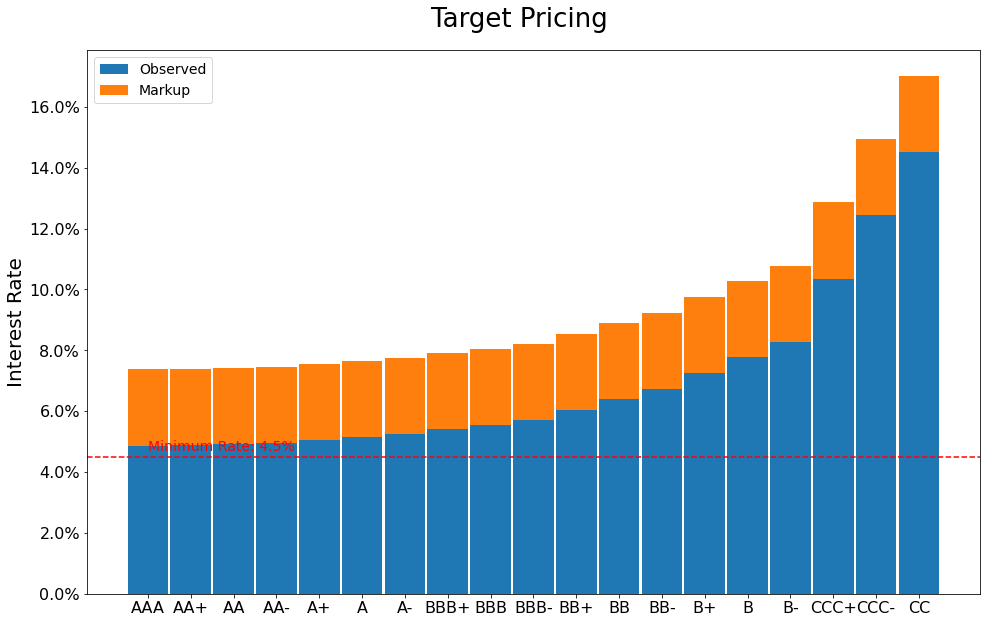

In [25]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    fig, ax = plt.subplots(figsize=(16,10))
    ax.bar(SPs, yields[:SPs.shape[0]], width=.95, label='Observed')
    ax.bar(
        SPs, rates[:SPs.shape[0]] - yields[:SPs.shape[0]], 
       width=.95, bottom=yields[:SPs.shape[0]], label='Markup'
    )
    ax.axhline(min_rate, color='r', ls='--')
    ax.text(0, .047, f'Minimum Rate: {min_rate:.1%}', color='r')
    
    ax.tick_params('x', labelsize=16)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
    
    ax.set_ylabel('Interest Rate')
    ax.legend()
    plt.suptitle('Target Pricing', y=.94)
    
    plt.show()

In [26]:
# Generate FMV depreciation curve
n_amort = 20
x = np.arange(n_amort*2)
mv_curve = line_by_line(x)

And below we see the assumed market value depreciation of the equipment being financed.

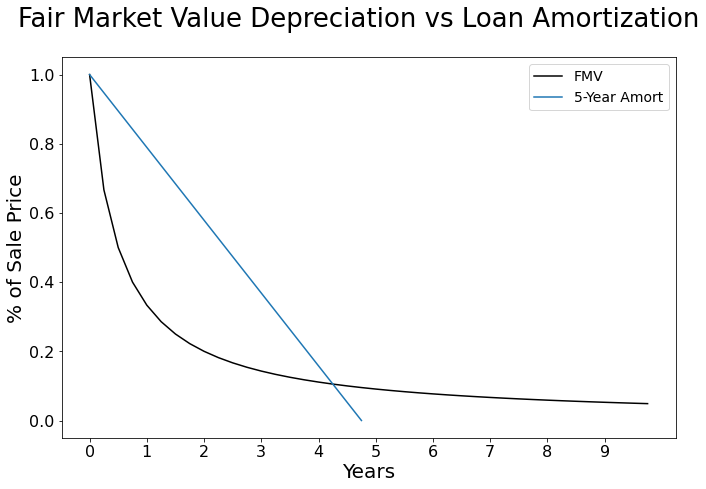

In [27]:
prin = np.linspace(1, 0, n_amort)

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(x, mv_curve, 'black', label='FMV')
ax.plot(x[:n_amort], prin, label='5-Year Amort')

ax.set_xticks([i for i in np.arange(40) if i % 4 == 0])
ax.set_xticklabels([i for i in np.arange(10)])

ax.set_xlabel('Years')
ax.set_ylabel('% of Sale Price')
ax.legend()
plt.suptitle('Fair Market Value Depreciation vs Loan Amortization')
plt.show()

In [28]:
# Generate FMV for each loan over the entire projection
std = 5000
lqd_exp = .1
fmv = nan_like(df_loans)
for x,y in loan_nums:
    dist = min(fmv.shape[1] - y, mv_curve.shape[0])
    fmv.iloc[x, y:y+dist] = df_loans.iloc[x, y]*mv_curve[:dist]
    
fmv.iloc[:, :] = norm.rvs(fmv, std)*(1-lqd_exp)

In [29]:
# Generate Projection
interest = nan_like(df_loans)
int_rates = []
econ_caps = np.zeros(df_loans.shape[1])
charge_offs = np.zeros(df_loans.shape[1])
n_amort = 5*4
n_samples = 15000
ba = .0042
spread = .01
debt_rate = ba + spread

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for vintage, col in df_loans.iteritems():
        print (f'Vintage: {vintage}', end='\r')
        if vintage > 0:
            df_loans, interest, econ_caps, charge_offs, int_rates = booksim(vintage, df_loans, p_of_ds, pd_idx, corrmats, fmv, interest, loan_nums, econ_caps, charge_offs, rates, int_rates, min_rate=min_rate, cost_of_debt=debt_rate, n_samples=15000)

### Financials ###

We can now build financial statements from the simulated data. 

<p class="p-break"></p>

The key consideration for assessing the project is including new sales by Opco (financed by Fico) in the cash flow assumption.

<p class="p-break"></p>

Key Assumptions:
+ Opco provides ALL capital support to Fico
+ Opco invests *both* debt *and* equity into Fico
+ Opco invests equity equal to economic capital required.
+ Remainder of Fico capital is injected as shareholder debt, charged at Opco's cost of debt.
+ In exchange for low interest rate on debt, 100% of Fico loans are sales by Opco.
+ New sales earn 15% gross margin
+ Assume \$150K in general expenses for Opco/Fico (paid for by Opco) growing at 7% per year

<p class="p-break"></p>

**Process for Fico**

1. create quarterly income statement and balance sheet
    + revenue found via interest on loans
    + charge-Offs found as Expected Losses from loss distribution generated from simulations in each quarter
    + pulled from projection:
        + Loans: Total advances less repayments and charge-offs
        + Req Equity: economic capital required as per Loss distribution in each quarter
    + implied:
        + Debt: difference between Loans and Req Equity.
        + Cash: cumulative profits generated (offset of Retained Earnings)
        + Net Debt: Debt less Cash (assumes Debt is reduced by whatever cash is avaialble)
3. adjust for interest expense shield from profits
4. consolidate to annual statements
5. create table of key ratios

<p class="p-break"></p>

**Process for Opco**

1. Generate Income Statement assuming 100% of new loan originations booked as revenue
2. Interest Expense earned is assumed to be offset by interest paid to Opco lender

<p class="p-break"></p>

**Handling Circular Debt/Income Relationship**

+ debt creates interest expense which lowers profitability which leads to higher debt
+ so there is an optimal level of debt that must be determined
+ the asset side of our balance sheet is fixed, i.e. the amount of loans is already known, we can find the debt level with some simple math. in our approach, we find the cash level, which is a function of the income, which then provides the debt level.

$Income_i = Revenue_i - ChargeOffs_i - (Debt_i - Cash_i)*Cost of Debt_i / 4
\\Loans_i = Debt_i + E_i = (Debt_i - Cash_i) + Required Equity_i + Retained Earnings_{i-1} + Income_i
\\Cash_i = Loans_i - Required Equity_i - Retained Earnings_{i-1} - Revenue + ChargeOffs + Debt*(Cost of Debt/4 - 1) / (Cost of Debt/4 - 1)
$

In [30]:
# Create IS and BS
index = ['Loans', 'Assets', 'Cash', 'Debt', 'Net Debt', 'Req Equity', 'Retained Earnings', 'Equity', 'D+E']
assets = df_loans.sum(axis=0)
debt = assets - econ_caps
cash = np.zeros_like(debt)
net = np.zeros_like(debt)
re = np.zeros_like(debt)
eq = np.zeros_like(debt)
de = np.zeros_like(debt)
BS = pd.DataFrame([assets, assets, cash, debt, net, econ_caps, re, eq, de], index=index).iloc[:, :periods]

index = ['Revenue', 'Charge Offs', 'Interest Exp', 'Profit']
cost_of_debt = np.zeros_like(debt)
prof = np.zeros_like(debt)
IS = pd.DataFrame([interest.sum(axis=0), charge_offs, cost_of_debt, prof], index=index).iloc[:, :periods]

In [38]:
# Adjust Interest Expense and Debt for profits
for i, col in BS.iteritems():
    re = 0 if i == 0 else BS.loc['Retained Earnings', i - 1]
    num = col.loc['Loans'] - col.loc['Req Equity'] - IS.loc['Revenue', i] \
        - re + IS.loc['Charge Offs', i] + col.loc['Debt']*(debt_rate/4 - 1)
    denom = (debt_rate/4 - 1)
    col.loc['Cash'] = -num/denom
    col.loc['Net Debt'] = col.loc['Debt'] + col.loc['Cash']

    IS.loc['Interest Exp', i] = col.loc['Net Debt']*debt_rate/4
    IS.loc['Profit', i] = IS.loc['Revenue', i] - IS.loc['Charge Offs', i] \
        - IS.loc['Interest Exp', i]
    
    col.loc['Retained Earnings'] = re + IS.loc['Profit', i]
    col.loc['Equity'] = col.loc['Retained Earnings']  + col.loc['Req Equity']

BS.loc['D+E'] = BS.loc['Net Debt'] + BS.loc['Equity']
BS.loc['bal'] = BS.loc['D+E'] - BS.loc['Assets']

# Aggregate to Annual 
IS_annual = IS.T.groupby(IS.T.index//4).sum().T
IS_annual.columns = np.arange(1, IS_annual.shape[1] + 1)

BS_annual = BS[np.arange(3,BS.shape[1],4)].T.reset_index(drop=True).T
BS_annual.columns = np.arange(1, BS_annual.shape[1] + 1)

# Create Table of Key Ratios
index = ['Cap Ratio', 'ROE', 'Charge-Off Rate']
caprat = BS_annual.loc['Equity'] / BS_annual.loc['Loans']
roe = IS_annual.loc['Profit'] / BS_annual.loc['Equity']
cumroe = IS_annual.loc['Profit'].cumsum() / BS_annual.loc['Equity'].iloc[-1]
co_annual = charge_offs[:periods].reshape(periods//4,4).sum(axis=1)
co_rate = co_annual / BS_annual.loc['Loans']
rats = pd.DataFrame([caprat, roe, co_rate], index=index)

We can see the results below. First, with the Income Statement:

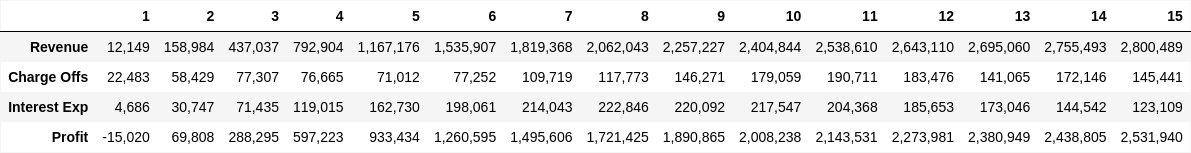

In [98]:
await dfi.export_async(IS_annual.style.format('{:,.0f}'), 'IS_annual.png')
Image('IS_annual.png')

Then, the Balance Sheet:

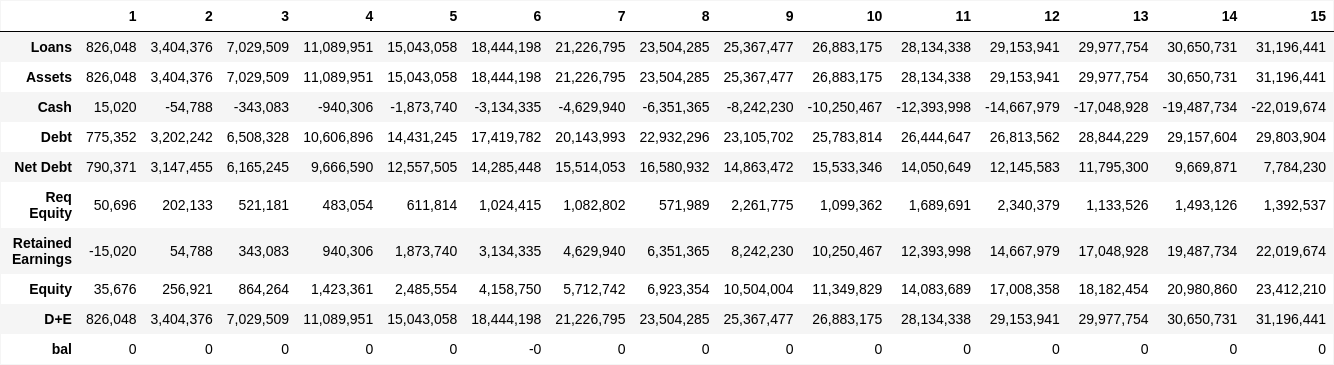

In [97]:
await dfi.export_async(BS_annual.style.format('{:,.0f}'), 'BS_annual.png')
Image('BS_annual.png')

Finally, we summarize some key ratios:

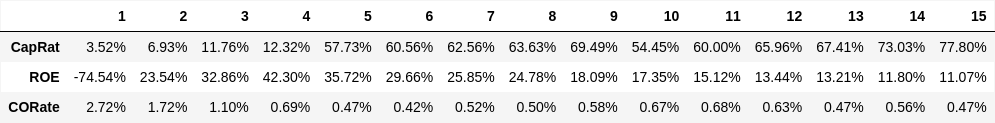

In [96]:
await dfi.export_async(rats.style.format('{:.2%}'), 'rats1.png')
Image('rats1.png')

In [42]:
index = ['Sales', 'Gross Profit', 'Interest Revenue']
sales = np.array([loan.sum() for loan in loans])
gm = .15
gp = sales*gm
int_rev = IS.loc['Interest Exp']

OPCO_IS = pd.DataFrame([sales, gp, int_rev], index=index).iloc[:, :periods]
OPCO_IS.loc['Gross Profit'] = np.where(OPCO_IS.loc['Gross Profit'].isna(), 0, OPCO_IS.loc['Gross Profit'])
OPCO_IS.loc['General Exp'] = 150000/4*((1 + .07/4)**np.arange(periods))
OPCO_IS.loc['Profit'] = OPCO_IS.loc['Gross Profit'] - OPCO_IS.loc['General Exp']

OPCOIS_annual = OPCO_IS.T.groupby(OPCO_IS.T.index//4).sum().T
OPCOIS_annual.columns = np.arange(1, OPCOIS_annual.shape[1] + 1)

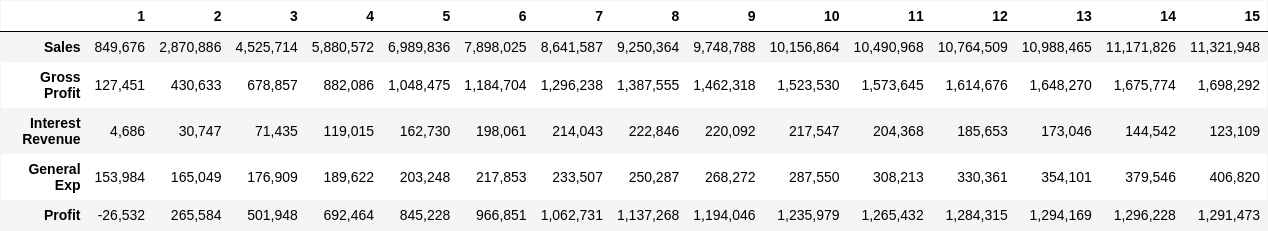

In [95]:
await dfi.export_async(OPCOIS_annual.style.format('{:,.0f}'), 'OPCOIS_annual.png')
Image('OPCOIS_annual.png')

Below we highlight some key details of the projection.

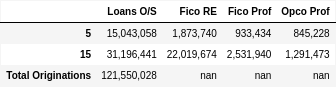

In [107]:
loans5 = BS_annual.loc['Loans', 5]
re5 = BS_annual.loc['Retained Earnings', 5]
fico_prof5 = IS_annual.loc['Profit', 5]
opco_prof5 = OPCOIS_annual.loc['Profit', 5]

loans15 = BS_annual.loc['Loans', 15]
re15 = BS_annual.loc['Retained Earnings', 15]
fico_prof15 = IS_annual.loc['Profit', 15]
opco_prof15 = OPCOIS_annual.loc['Profit', 15]

# html = '<table>'
# html +=  '<thead>'
# html +=    '<tr>'
# html +=      '<th>Year</th><th>Loans O/S</th><th>Fico RE</th><th>Fico Prof</th><th>Opco Prof</th>'
# html +=    '</tr>'
# html +=  '</thead>'
# html +=  '<tbody>'
# html +=    '<tr>'
# html +=      f'<td>5</td><td>{loans5:,.0f}</td>'
# html +=      f'<td>{re5:,.0f}</td>'
# html +=      f'<td>{fico_prof5:,.0f}</td>'
# html +=      f'<td>{opco_prof5:,.0f}</td>'
# html +=    '</tr>'
# html +=    '<tr>'
# html +=      f'<td>15</td><td>{loans15:,.0f}</td>'
# html +=      f'<td>{re15:,.0f}</td>'
# html +=      f'<td>{fico_prof15:,.0f}</td>'
# html +=      f'<td>{opco_prof15:,.0f}</td>'
# html +=    '</tr>'
# html +=  '</tbody>'
# html +=  '<tfoot>'
# html +=    '<tr>'
# html +=      f'<td colspan=3>Total Originations: {originations.sum():,.0f}</td>'
# html +=    '</tr>'
# html +=  '</tfoot>'
# html += '</table>'

# display(HTML(html))

# Create DataFrame matching the HTML table above
data = {
    'Loans O/S': [loans5, loans15],
    'Fico RE': [re5, re15],
    'Fico Prof': [fico_prof5, fico_prof15], 
    'Opco Prof': [opco_prof5, opco_prof15]
}

df = pd.DataFrame(data, index=[5, 15])
df.index.name = 'Year'

# Add total originations as a footer
footer = pd.DataFrame({'Loans O/S': originations.sum()}, index=['Total Originations'])
df = pd.concat([df, footer])

await dfi.export_async(df.style.format('{:,.0f}'), 'df1.png', fontsize=10)
Image('df1.png')


### Investment Evaluation ###

We can now use our projections to evaluate the value of the investment to Opcos' shareholders using **Internal Rate of Return (IRR)** and **Net Present Value (NPV)**.

<p class="p-break"></p>

Assumptions:

+ Cash outflows (generally debt or equity investments) and inflows (profit or proceeds of financing) are netted for each year. 
+ A terminal value is determined using a multiple of Year 15 profit, discounted back to present
    + Opco TV multiple of 5.5x
    + Fico TV multiple of 5.5x

In [45]:
discount = .10
fico_mult = opco_mult = 5.5

d_co = BS_annual.loc['Net Debt'].shift(1).fillna(0) - BS_annual.loc['Net Debt']
d_ci = OPCOIS_annual.loc['Profit']
opco_tv = OPCOIS_annual.loc['Profit', 15]*fico_mult

d_co.loc[d_co.shape[0] + 1] = 0
d_ci.loc[d_ci.shape[0] + 1] = opco_tv

d_irr = npf.irr(d_co + d_ci)
d_npv = npf.npv(discount, d_co + d_ci)

e_co = -(BS_annual.loc['Req Equity'] - BS_annual.loc['Req Equity'].shift(1).fillna(0))
e_ci = IS_annual.loc['Profit']
fico_tv = IS_annual.loc['Profit', 15]*opco_mult

e_co.loc[e_co.shape[0]+1] = 0
e_ci.loc[e_ci.shape[0]+1] = fico_tv

e_irr = npf.irr(e_co + e_ci)
e_npv = npf.npv(discount, e_co + e_ci)

irr = npf.irr(d_co + d_ci + e_co + e_ci)
npv = npf.npv(discount, d_co + d_ci + e_co + e_ci)

irr_ex_tv = npf.irr(d_co[:-1] + d_ci[:-1] + e_co[:-1] + e_ci[:-1])
npv_ex_tv = npf.npv(discount, d_co[:-1] + d_ci[:-1] + e_co[:-1] + e_ci[:-1])

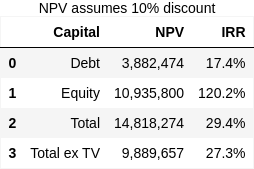

In [93]:
# html = '<table>'
# html +=  '<thead>'
# html +=    '<tr>'
# html +=      '<th>Capital</th><th>NPV</th><th>IRR</th>'
# html +=    '</tr>'
# html +=  '</thead>'
# html +=  '<tbody>'
# html +=    '<tr>'
# html +=      f'<td>Debt</td><td>{d_npv:,.0f}</td><td>{d_irr:.1%}</td>'
# html +=    '</tr>'
# html +=    '<tr>'
# html +=      f'<td>Equity</td><td>{e_npv:,.0f}</td><td>{e_irr:.1%}</td>'
# html +=    '</tr>'
# html +=    '<tr>'
# html +=      f'<td>Total</td><td>{npv:,.0f}</td><td>{irr:.1%}</td>'
# html +=    '</tr>'
# html +=    '<tr>'
# html +=      f'<td>Total ex TV</td><td>{npv_ex_tv:,.0f}</td><td>{irr_ex_tv:.1%}</td>'
# html +=    '</tr>'
# html +=  '</tbody>'
# html +=  '<tfoot>'
# html +=    '<tr>'
# html +=      '<td colspan=3>NPV assumes 10% discount</td>'
# html +=    '</tr>'
# html +=  '</tfoot>'
# html += '</table>'

# display(HTML(html))

df = pd.DataFrame({
    'Capital': ['Debt', 'Equity', 'Total', 'Total ex TV'],
    'NPV': [d_npv, e_npv, npv, npv_ex_tv],
    'IRR': [d_irr, e_irr, irr, irr_ex_tv]
})

df['NPV'] = df['NPV'].map('{:,.0f}'.format)
df['IRR'] = df['IRR'].map('{:.1%}'.format)

await dfi.export_async(df.style.set_caption('NPV assumes 10% discount'), 'df.png', fontsize=10)
Image('df.png')

### 3rd Party Borrowing ###

We will adjust the evaluation above to consider the impact of acquiring 3rd party financing for Fico at the 5-year mark. The addition of 3rd party financing should reduce Opco capital requirements and enhance the project's return.

<p class="p-break"></p>

Assumptions:

+ Year 0 - 5: 0% of debt financed by 3rd Party
+ Year 5 - 10: 50% of debt financed by 3rd Party
+ Year 10 - 15: 75% of debt financed by 3rd Party
+ 3rd Party Finance Rate: 2.75%

In [47]:
BS3 = BS_annual.copy(deep=True)
IS3 = IS_annual.copy(deep=True)
OPCO_IS3 = OPCOIS_annual.copy(deep=True)

bank_debt_rate = .0275

BS3.loc['Bank Debt'] = 0
BS3.loc['Shhr Debt'] = 0
BS3.loc['Retained Earnings'] = 0
BS3 = BS3.reindex(['Loans', 'Assets', 'Cash', 'Debt', 'Bank Debt', 'Shhr Debt', 'Net Debt', 'Req Equity', 'Retained Earnings', 'Equity', 'D+E'])

OPCO_IS3.loc['General Exp'] = 150000*((1 + .07)**np.arange(15))

OPCO_IS3 = OPCO_IS3.reindex(['Sales', 'Gross Profit', 'Interest Revenue', 'General Exp', 'Profit'])
OPCO_IS3.loc['Profit'] = OPCO_IS3.loc['Gross Profit'] - OPCO_IS3.loc['General Exp']

# Adjust Interest Expense and Debt for profits
for i, col in BS3.iteritems():
    bank_factor = 0 if i < 5 else (.5 if i < 10 else .75)
    rate_factor = debt_rate if i < 5 else ((debt_rate + bank_debt_rate)*.5 if i < 10 else (bank_debt_rate*.75 + debt_rate*.25))
    re = 0 if i == 1 else BS3.loc['Retained Earnings', i - 1]
    num = col.loc['Loans'] - col.loc['Req Equity'] - IS3.loc['Revenue', i] \
        - re + IS3.loc['Charge Offs', i] + col.loc['Debt']*(rate_factor - 1)
    denom = rate_factor - 1

    col.loc['Cash'] = -num/denom
    col.loc['Net Debt'] = col.loc['Debt'] + col.loc['Cash']
    col.loc['Bank Debt'] = col.loc['Net Debt']*bank_factor
    col.loc['Shhr Debt'] = col.loc['Net Debt'] - col.loc['Bank Debt']

    IS3.loc['Interest Exp', i] = col.loc['Shhr Debt']*debt_rate + col.loc['Bank Debt']*bank_debt_rate 
    IS3.loc['Profit', i] = IS3.loc['Revenue', i] - IS3.loc['Charge Offs', i] \
        - IS3.loc['Interest Exp', i]
    
    col.loc['Retained Earnings'] = re + IS3.loc['Profit', i]
    col.loc['Equity'] = col.loc['Retained Earnings']  + col.loc['Req Equity']

BS3.loc['D+E'] = BS3.loc['Net Debt'] + BS3.loc['Equity']
BS3.loc['bal'] = BS3.loc['D+E'] - BS3.loc['Assets']
BS3.loc['bal2'] = BS3.loc['D+E'] - BS3.loc[['Bank Debt', 'Shhr Debt', 'Req Equity', 'Retained Earnings']].sum()


index = ['CapRat', 'ROE', 'CORate']
tnw = np.where(BS3.columns >= 5, BS3.loc['Equity'] + BS3.loc['Shhr Debt'],  BS3.loc['Equity'])
caprat = tnw / BS3.loc['Loans']
roe = IS3.loc['Profit'] / BS3.loc['Equity']
cumroe = IS3.loc['Profit'].cumsum() / BS3.loc['Equity'].iloc[-1]
co_annual = charge_offs[:periods].reshape(periods//4,4).sum(axis=1)
co_rate = co_annual / BS3.loc['Loans']
rats = pd.DataFrame([caprat, roe, co_rate], index=index)

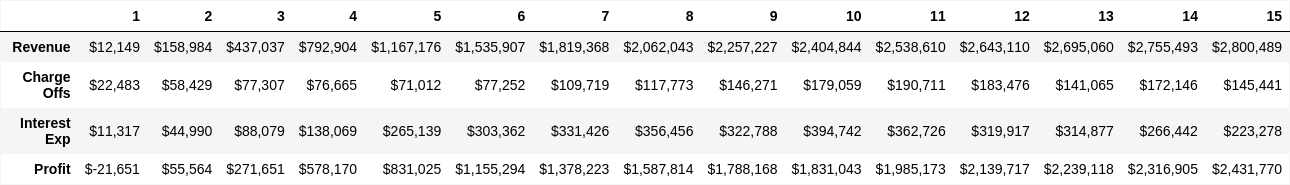

In [82]:
await dfi.export_async(IS3.style.format('${:,.0f}'), 'IS3.png', fontsize=16)
Image('IS3.png')

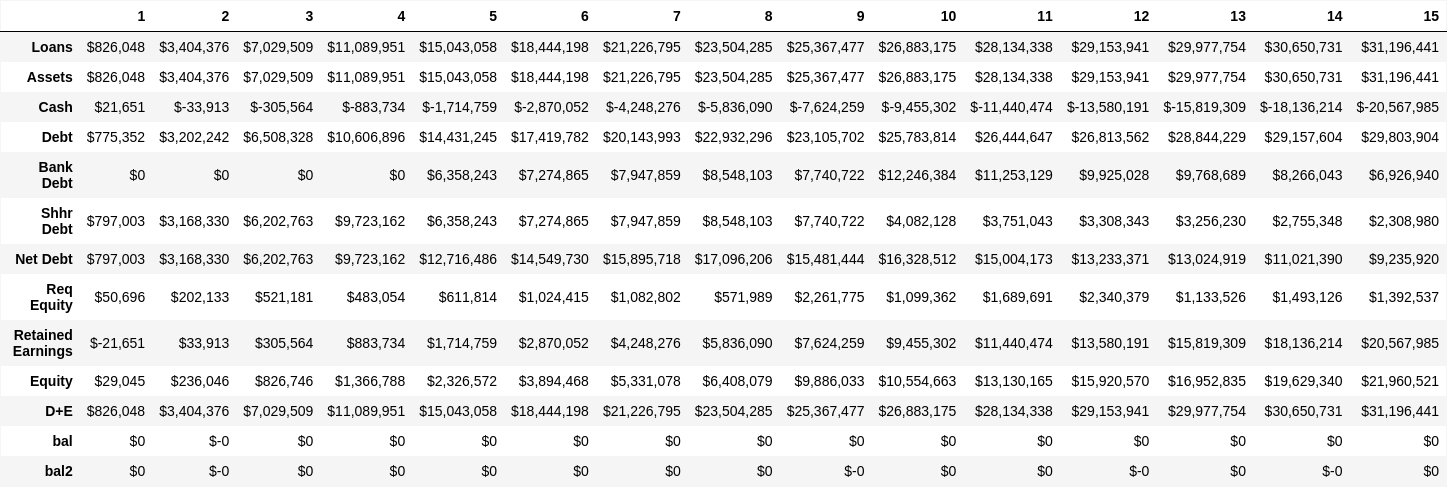

In [83]:
await dfi.export_async(BS3.style.format('${:,.0f}'), 'BS3.png', fontsize=16)
Image('BS3.png')

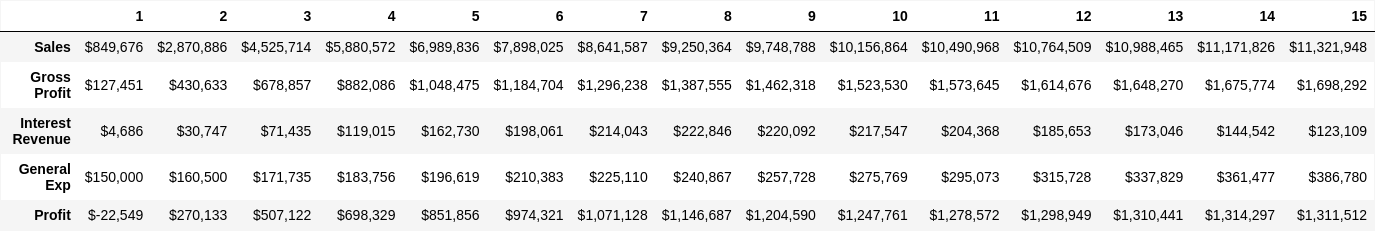

In [84]:
await dfi.export_async(OPCO_IS3.style.format('${:,.0f}'), 'OPCO_IS3.png', fontsize=16)
Image('OPCO_IS3.png')

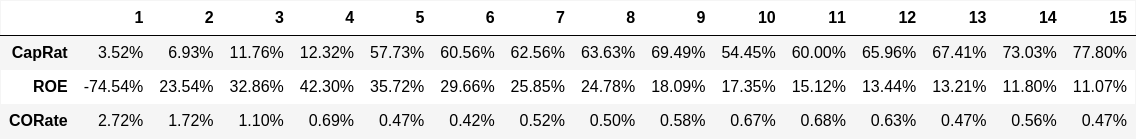

In [104]:
await dfi.export_async(rats.style.format('{:.2%}'), 'rats.png', fontsize=16)
Image('rats.png')


In [52]:
discount = .10

d_co = BS3.loc['Shhr Debt'].shift(1).fillna(0) - BS3.loc['Shhr Debt']
d_ci = OPCO_IS3.loc['Profit']
opco_tv = OPCO_IS3.loc['Profit', 15]*fico_mult

d_co.loc[d_co.shape[0] + 1] = 0
d_ci.loc[d_ci.shape[0] + 1] = opco_tv

d_irr = npf.irr(d_co + d_ci)
d_npv = npf.npv(discount, d_co + d_ci)

e_co = -(BS3.loc['Req Equity'] - BS3.loc['Req Equity'].shift(1).fillna(0))
e_ci = IS3.loc['Profit']
fico_tv = IS3.loc['Profit', 15]*opco_mult

e_co.loc[e_co.shape[0]+1] = 0
e_ci.loc[e_ci.shape[0]+1] = fico_tv

e_irr = npf.irr(e_co + e_ci)
e_npv = npf.npv(discount, e_co + e_ci)

irr = npf.irr(d_co + d_ci + e_co + e_ci)
npv = npf.npv(discount, d_co + d_ci + e_co + e_ci)

irr_ex_tv = npf.irr(d_co[:-1] + d_ci[:-1] + e_co[:-1] + e_ci[:-1])
npv_ex_tv = npf.npv(discount, d_co[:-1] + d_ci[:-1] + e_co[:-1] + e_ci[:-1])

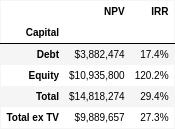

In [102]:
df = pd.DataFrame({
    'NPV': [d_npv, e_npv, npv, npv_ex_tv],
    'IRR': [d_irr, e_irr, irr, irr_ex_tv]
}, index=['Debt', 'Equity', 'Total', 'Total ex TV'])
df.index.name = 'Capital'

await dfi.export_async(df.style.format({
    'NPV': '${:,.0f}',
    'IRR': '{:.1%}'
}), 'df.png', fontsize=6)
Image('df.png')


We can above that refinancing of shareholder loans via standard 3rd party debt (likely bank debt) can significantly improve shareholder returns.

In [114]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [115]:
%load_ext autoreload
%autoreload 2

from htsfi.main import *

move_to_doc_folder('standard.ipynb')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
